<a href="https://colab.research.google.com/github/RitwickRoy/Machine_Learning_Notebooks/blob/main/Bankruptcy_prediction_class_imbalance_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**<font size="3">Project Overview</font>**
1. [Importing Dataset](#Importing_dataset)<br>
    1.1. [Data Schema](#Schema)<br>
    1.2. [Renaming Features](#Renaming_Features)<br>
    1.3. [Summary Statistics](#Summary_Stats)<br>
2. [Exploratory Data Analysis](#Exploratory_Data_Analysis)<br>
    2.1. [Average ratios](#Average_ratio)<br>
    2.2. [Missing data](#Missing_data)<br>
    2.3. [Feature Relationships](#Feature_relationships)<br>
    2.4  [Dominant Features](#Dom_Feat)<br>
    2.4.1. [PCA](#PCA)<br>
    2.4.2. [Feature Importance](#Feature_Importance)<br>
    2.4.3. [Distributions](#Distributions)<br>
    2.5. [EDA Summary](#EDA_Summary)<br> 
3. [Data Preparation](#Data_Preparation)<br>
    3.1. [Detecting outliers: Local outlier Factor](#LOF)<br>
4. [Model Training](#MT)<br>
    4.1 [Baseline case](#Basline)<br>
    4.1.1 [Model training with oversampled data](#MT_OS)<br>
    4.1.2 [Model training with undersampled data](#MT_US)<br>
    4.1.3 [Model building: SMOTE](#BM)<br>
    4.1.4 [Model building: ADASYN](#BM)<br>
    4.1.5 [Model building: PCA and SMOTE](#PCA_SMOTE)<br>
5. [Conclusion](#Conclusion)<br>


* **Overview:**
Bankruptcies exert negative forces on the economy by discouraging investors from investing. Investors, businesses and government institutions want to minimize bankruptcies to promote a heathy economy. Predicting bankruptcy is critical to achieving this goal because businesses even those that starts off well may end up in bankruptcies.  Financial institutions in particular want models that can predict the likelihood of a firm going bankrupt in order to make a sound lending decision. In this project we will work with a dataset consisting of financial information of various companies to build a bankruptcy prediction model.
* **Dataset:**
Market forces and corporate governance influence the performance of a firm. Financial ratios capture the solvency, profitability, cash flow and growth of a firm. Financial ratios are considered strong indicators of poor financial performance leading to bankruptcy.  The dataset consists of data collected from the Taiwan Economic Journal for the years 1999 to 2009. Bankruptcy is defined as a binary label (1 indicating bankruptcy and 0 indicating no bankruptcy).  The labels are derived based on regulations set by the Taiwan Stock Exchange. The first criterion for selecting a company was that the company had to have at least three year of public information prior to bankruptcy. The second criterion was to have sufficient number of similar sized companies from the different sectors of the economy. The dataset includes companies from the industrial manufacturing sector, the electronic manufacturing sector, the shipping industry, the tourism industry and the retail sectors. Financial companies are not included in the dataset.  Together there are 6819 data points (rows). There is a significant class imbalance between bankruptcy (220) vs non-bankruptcy (6599) in the dataset.  There are 95 features in the dataset. These features include ROA, current ratio, debt ratio, liability to equity ratio etc. Only two of the 95 features are categorical features. The remaining 93 features are continuous real valued variables.


<a id='Importing_dataset'></a>
## 1. Importing dataset

* **Use pySpark for reading the data**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [7]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.0.2/spark-3.0.2-bin-hadoop2.7.tgz
!tar xf spark-3.0.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [9]:
import findspark
findspark.init("spark-3.0.2-bin-hadoop2.7")# SPARK_HOME)
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col,column,expr,lit,corr,udf,count,countDistinct,min,max,avg,mean,stddev_pop,stddev_samp,desc,asc,translate,regexp_replace
from pyspark.sql.types import StructField,StructType,StringType,IntegerType,LongType
import pyspark.sql.functions as F
from sklearn.neighbors import LocalOutlierFactor
from numpy import where
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, metrics
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB  
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN

In [11]:
bankruptcy = spark.read.format('csv').option('header',"true").option('inferSchema',"true").load('CompanyBankruptcyPrediction.csv')
bankruptcy.show(3)

+---------+--------------------------------------------------------+---------------------------------------+--------------------------------------------------+-----------------------+----------------------------+----------------------+--------------------------+----------------------------+--------------------------------------------+-------------------------------------+-----------------------+--------------------------------------+-----------------+------------------------------------+-------------+------------------------+------------------------+------------------------+----------------------------------------+--------------------+---------------------------+------------------------------------+-----------------------------------------+----------------------------------------+-----------------------------+---------------------------------+-------------------------------+----------------------------------+------------------------+----------------------+------------------------------

<a id='Schema'></a>
### 1.1 Data Schema

In [12]:
bankruptcy = bankruptcy.withColumnRenamed('Bankrupt?','Bankrupt')

* **Schema for the dataset**

In [13]:
bankruptcy.printSchema()

root
 |-- Bankrupt: integer (nullable = true)
 |--  ROA(C) before interest and depreciation before interest: double (nullable = true)
 |--  ROA(A) before interest and % after tax: double (nullable = true)
 |--  ROA(B) before interest and depreciation after tax: double (nullable = true)
 |--  Operating Gross Margin: double (nullable = true)
 |--  Realized Sales Gross Margin: double (nullable = true)
 |--  Operating Profit Rate: double (nullable = true)
 |--  Pre-tax net Interest Rate: double (nullable = true)
 |--  After-tax net Interest Rate: double (nullable = true)
 |--  Non-industry income and expenditure/revenue: double (nullable = true)
 |--  Continuous interest rate (after tax): double (nullable = true)
 |--  Operating Expense Rate: double (nullable = true)
 |--  Research and development expense rate: double (nullable = true)
 |--  Cash flow rate: double (nullable = true)
 |--  Interest-bearing debt interest rate: double (nullable = true)
 |--  Tax rate (A): double (nullable = tr

<a id='Renaming_Features'></a>
### 1.2 Renaming features

* **Rename column to abbreviated form and eliminate the leading blank**

In [15]:
bankruptcy = bankruptcy.withColumnRenamed(' ROA(C) before interest and depreciation before interest',"ROA(C)")\
                       .withColumnRenamed(' ROA(A) before interest and % after tax',"ROA(A)")\
                       .withColumnRenamed(' ROA(B) before interest and depreciation after tax',"ROA(B)")\
                       .withColumnRenamed(' Operating Gross Margin',"OGM")\
                       .withColumnRenamed(' Realized Sales Gross Margin',"RSGM")\
                       .withColumnRenamed(' Operating Profit Rate',"OPR")\
                       .withColumnRenamed(' Pre-tax net Interest Rate',"PNIR")\
                       .withColumnRenamed(' After-tax net Interest Rate',"ANIR")\
                       .withColumnRenamed(' Non-industry income and expenditure/revenue',"NIIER")\
                       .withColumnRenamed(' Continuous interest rate (after tax)',"CIR")\
                       .withColumnRenamed(' Operating Expense Rate',"OER")\
                       .withColumnRenamed(' Research and development expense rate',"RDER")\
                       .withColumnRenamed(' Cash flow rate',"CFR")\
                       .withColumnRenamed(' Interest-bearing debt interest rate',"IBDIR")\
                       .withColumnRenamed(' Tax rate (A)',"TR(A)")\
                       .withColumnRenamed(' Net Value Per Share (B)',"NVPS(B")\
                       .withColumnRenamed(' Net Value Per Share (A)',"NVPS(A)")\
                       .withColumnRenamed(' Net Value Per Share (C)',"NVPS(C)")\
                       .withColumnRenamed(' Persistent EPS in the Last Four Seasons',"PEPS")\
                       .withColumnRenamed(' Cash Flow Per Share',"CFPS")\
                       .withColumnRenamed(' Revenue Per Share (Yuan ¥)',"RPSY")\
                       .withColumnRenamed(' Operating Profit Per Share (Yuan ¥)',"OPPSY")\
                       .withColumnRenamed(' Per Share Net profit before tax (Yuan ¥)',"PSNPY")\
                       .withColumnRenamed(' Realized Sales Gross Profit Growth Rate',"RSGPGR")\
                       .withColumnRenamed(' Operating Profit Growth Rate',"OPGR")\
                       .withColumnRenamed(' After-tax Net Profit Growth Rate',"ATNPGR")\
                       .withColumnRenamed(' Regular Net Profit Growth Rate',"RNPGR")\
                       .withColumnRenamed(' Continuous Net Profit Growth Rate',"CNPGR")\
                       .withColumnRenamed(' Total Asset Growth Rate',"TAGR")\
                       .withColumnRenamed(' Net Value Growth Rate',"NVGR")\
                       .withColumnRenamed(' Total Asset Return Growth Rate Ratio',"TARGRR")\
                       .withColumnRenamed(' Cash Reinvestment %',"CRP")\
                       .withColumnRenamed(' Current Ratio',"CR")\
                       .withColumnRenamed(' Quick Ratio',"QR")\
                       .withColumnRenamed(' Interest Expense Ratio',"IER")\
                       .withColumnRenamed(' Total debt/Total net worth',"TDTNW")\
                       .withColumnRenamed(' Debt ratio %',"DRP")\
                       .withColumnRenamed(' Net worth/Assets',"NWA")\
                       .withColumnRenamed(' Long-term fund suitability ratio (A)',"LTFSR")\
                       .withColumnRenamed(' Borrowing dependency',"BD")\
                       .withColumnRenamed(' Contingent liabilities/Net worth',"CLNW")\
                       .withColumnRenamed(' Operating profit/Paid-in capital',"OPPIC")\
                       .withColumnRenamed(' Net profit before tax/Paid-in capital',"NPPIC")\
                       .withColumnRenamed(' Inventory and accounts receivable/Net value',"IAR")\
                       .withColumnRenamed(' Total Asset Turnover',"TAT")\
                       .withColumnRenamed(' Accounts Receivable Turnover',"ART")\
                       .withColumnRenamed(' Average Collection Days',"ACD")\
                       .withColumnRenamed(' Inventory Turnover Rate (times)',"ITR")\
                       .withColumnRenamed(' Fixed Assets Turnover Frequency',"FATF")\
                       .withColumnRenamed(' Net Worth Turnover Rate (times)',"NWTR")\
                       .withColumnRenamed(' Revenue per person',"RPP")\
                       .withColumnRenamed(' Operating profit per person',"OPPP")\
                       .withColumnRenamed(' Allocation rate per person',"ARPP")\
                       .withColumnRenamed(' Working Capital to Total Assets',"WCTA")\
                       .withColumnRenamed(' Quick Assets/Total Assets',"QATA")\
                       .withColumnRenamed(' Current Assets/Total Assets',"CATA")\
                       .withColumnRenamed(' Cash/Total Assets',"CTA")\
                       .withColumnRenamed(' Quick Assets/Current Liability',"QACL")\
                       .withColumnRenamed(' Cash/Current Liability',"CACL")\
                       .withColumnRenamed(' Current Liability to Assets',"CLTA")\
                       .withColumnRenamed(' Operating Funds to Liability',"OFTL")\
                       .withColumnRenamed(' Inventory/Working Capital',"IWC")\
                       .withColumnRenamed(' Inventory/Current Liability',"ICL")\
                       .withColumnRenamed(' Current Liabilities/Liability',"CLSTL")\
                       .withColumnRenamed(' Working Capital/Equity',"WCE")\
                       .withColumnRenamed(' Current Liabilities/Equity',"CLE")\
                       .withColumnRenamed(' Long-term Liability to Current Assets',"LLCA")\
                       .withColumnRenamed(' Retained Earnings to Total Assets',"RETA")\
                       .withColumnRenamed(' Total income/Total expense',"TITE")\
                       .withColumnRenamed(' Total expense/Assets',"TEA")\
                       .withColumnRenamed(' Current Asset Turnover Rate',"CATR")\
                       .withColumnRenamed(' Quick Asset Turnover Rate',"QATR")\
                       .withColumnRenamed(' Working capitcal Turnover Rate',"WCTR")\
                       .withColumnRenamed(' Cash Turnover Rate',"CTR")\
                       .withColumnRenamed(' Cash Flow to Sales',"CFS")\
                       .withColumnRenamed(' Fixed Assets to Assets',"FAA")\
                       .withColumnRenamed(' Current Liability to Liability',"CLTL")\
                       .withColumnRenamed(' Current Liability to Equity',"CLTE")\
                       .withColumnRenamed(' Equity to Long-term Liability',"ETLTL")\
                       .withColumnRenamed(' Cash Flow to Total Assets',"CFTA")\
                       .withColumnRenamed(' Cash Flow to Liability',"CFL")\
                       .withColumnRenamed(' CFO to Assets',"CFOA")\
                       .withColumnRenamed(' Cash Flow to Equity',"CFTE")\
                       .withColumnRenamed(' Current Liability to Current Assets',"CLTCA")\
                       .withColumnRenamed(' Liability-Assets Flag',"LAF")\
                       .withColumnRenamed(' Net Income to Total Assets',"NITTA")\
                       .withColumnRenamed(' Total assets to GNP price',"TATGNPP")\
                       .withColumnRenamed(' No-credit Interval',"NCI")\
                       .withColumnRenamed(' Gross Profit to Sales',"GPTS")\
                       .withColumnRenamed(' Liability to Equity',"LTE")\
                       .withColumnRenamed(' Degree of Financial Leverage (DFL)',"DFL")\
                       .withColumnRenamed(' Interest Coverage Ratio (Interest expense to EBIT)',"ICRIETEBIT")\
                       .withColumnRenamed(' Net Income Flag',"NIF")\
                       .withColumnRenamed(' Equity to Liability',"ETL")\
                       .withColumnRenamed(" Net Income to Stockholder\'s Equity","NITS")    
                       

* *Important: Examine each column to ensure that the ratios are within expected range.*

<a id='Summary_Stats'></a>
### 1.3. Summary Statistics

In [16]:
bankr_descrb = bankruptcy.describe()
bankr_descrb.show()

+-------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+----

* **Number of data points**

In [31]:
bankruptcy.count()

6819

<a id='Exploratory_Data_Analysis'></a>
## 2. Exploratory Data Analysis
<a id='Average ratios'></a>
### 2.1. Average ratios

In [23]:
avgratio = bankruptcy.groupBy('Bankrupt').mean()
avgratio.show(truncate=8)

+--------+-------------+-----------+-----------+-----------+--------+---------+--------+---------+---------+----------+--------+--------+---------+--------+----------+----------+-----------+------------+------------+---------+---------+---------+----------+----------+-----------+---------+-----------+----------+----------+---------+---------+-----------+--------+--------+--------+--------+----------+--------+--------+----------+--------+---------+----------+----------+--------+--------+--------+--------+--------+---------+---------+--------+---------+---------+---------+---------+---------+--------+---------+---------+---------+---------+--------+--------+----------+--------+--------+---------+---------+---------+--------+---------+---------+---------+--------+--------+--------+---------+---------+----------+---------+--------+---------+---------+----------+--------+----------+------------+--------+---------+---------+--------+--------+---------------+--------+--------+
|Bankrupt|avg(B

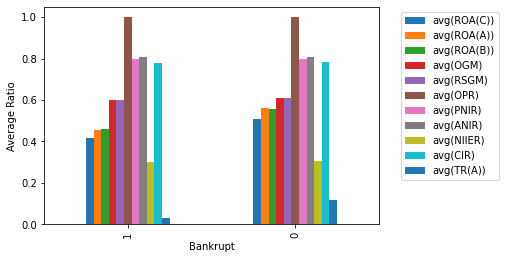

In [21]:
avgratio_py = avgratio.toPandas()
colm = ["avg(ROA(C))","avg(ROA(A))","avg(ROA(B))","avg(OGM)","avg(RSGM)","avg(OPR)","avg(PNIR)","avg(ANIR)","avg(NIIER)","avg(CIR)","avg(TR(A))"]
avgratio_py.plot(x="Bankrupt",y=colm,kind="bar")
plt.ylabel('Average Ratio')
plt.legend(bbox_to_anchor=(1.05, 1.0),loc="upper left")

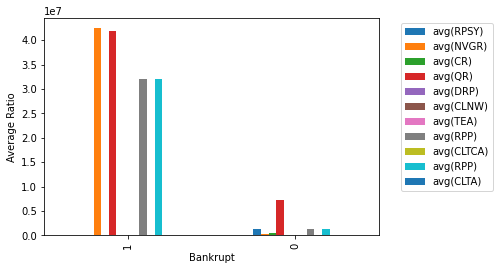

In [22]:
avgratio_py = avgratio.toPandas()
colm = ["avg(RPSY)","avg(NVGR)","avg(CR)","avg(QR)","avg(DRP)","avg(CLNW)","avg(TEA)","avg(RPP)","avg(CLTCA)","avg(RPP)","avg(CLTA)"]
avgratio_py.plot(x="Bankrupt",y=colm,kind="bar")
plt.ylabel('Average Ratio')
plt.legend(bbox_to_anchor=(1.05, 1.0),loc="upper left")

<a id='Missing_Data_Corr'></a>
### 2.2. Look for missing data

In [24]:
bankruptcy_pd = bankruptcy.toPandas()
bankruptcy_pd.head(2)

,Bankrupt,ROA(C),ROA(A),ROA(B),OGM,RSGM,OPR,PNIR,ANIR,NIIER,CIR,OER,RDER,CFR,IBDIR,TR(A),NVPS(B,NVPS(A),NVPS(C),PEPS,CFPS,RPSY,OPPSY,PSNPY,RSGPGR,OPGR,ATNPGR,RNPGR,CNPGR,TAGR,NVGR,TARGRR,CRP,CR,QR,IER,TDTNW,DRP,NWA,LTFSR,...,CATA,CTA,QACL,CACL,CLTA,OFTL,IWC,ICL,CLSTL,WCE,CLE,LLCA,RETA,TITE,TEA,CATR,QATR,WCTR,CTR,CFS,FAA,CLTL,CLTE,ETLTL,CFTA,CFL,CFOA,CFTE,CLTCA,LAF,NITTA,TATGNPP,NCI,GPTS,NITS,LTE,DFL,ICRIETEBIT,NIF,ETL
0,1,0.370594,0.424389,0.40575,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.000126,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,0.000147,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.51673,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.000290,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,0.001384,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794


In [32]:
bankruptcy_pd.isna().sum()

Bankrupt      0
ROA(C)        0
ROA(A)        0
ROA(B)        0
OGM           0
             ..
LTE           0
DFL           0
ICRIETEBIT    0
NIF           0
ETL           0
Length: 96, dtype: int64

* **no missing data**

<a id='Feature_relationships'></a>
### 2.3. Feature relationships

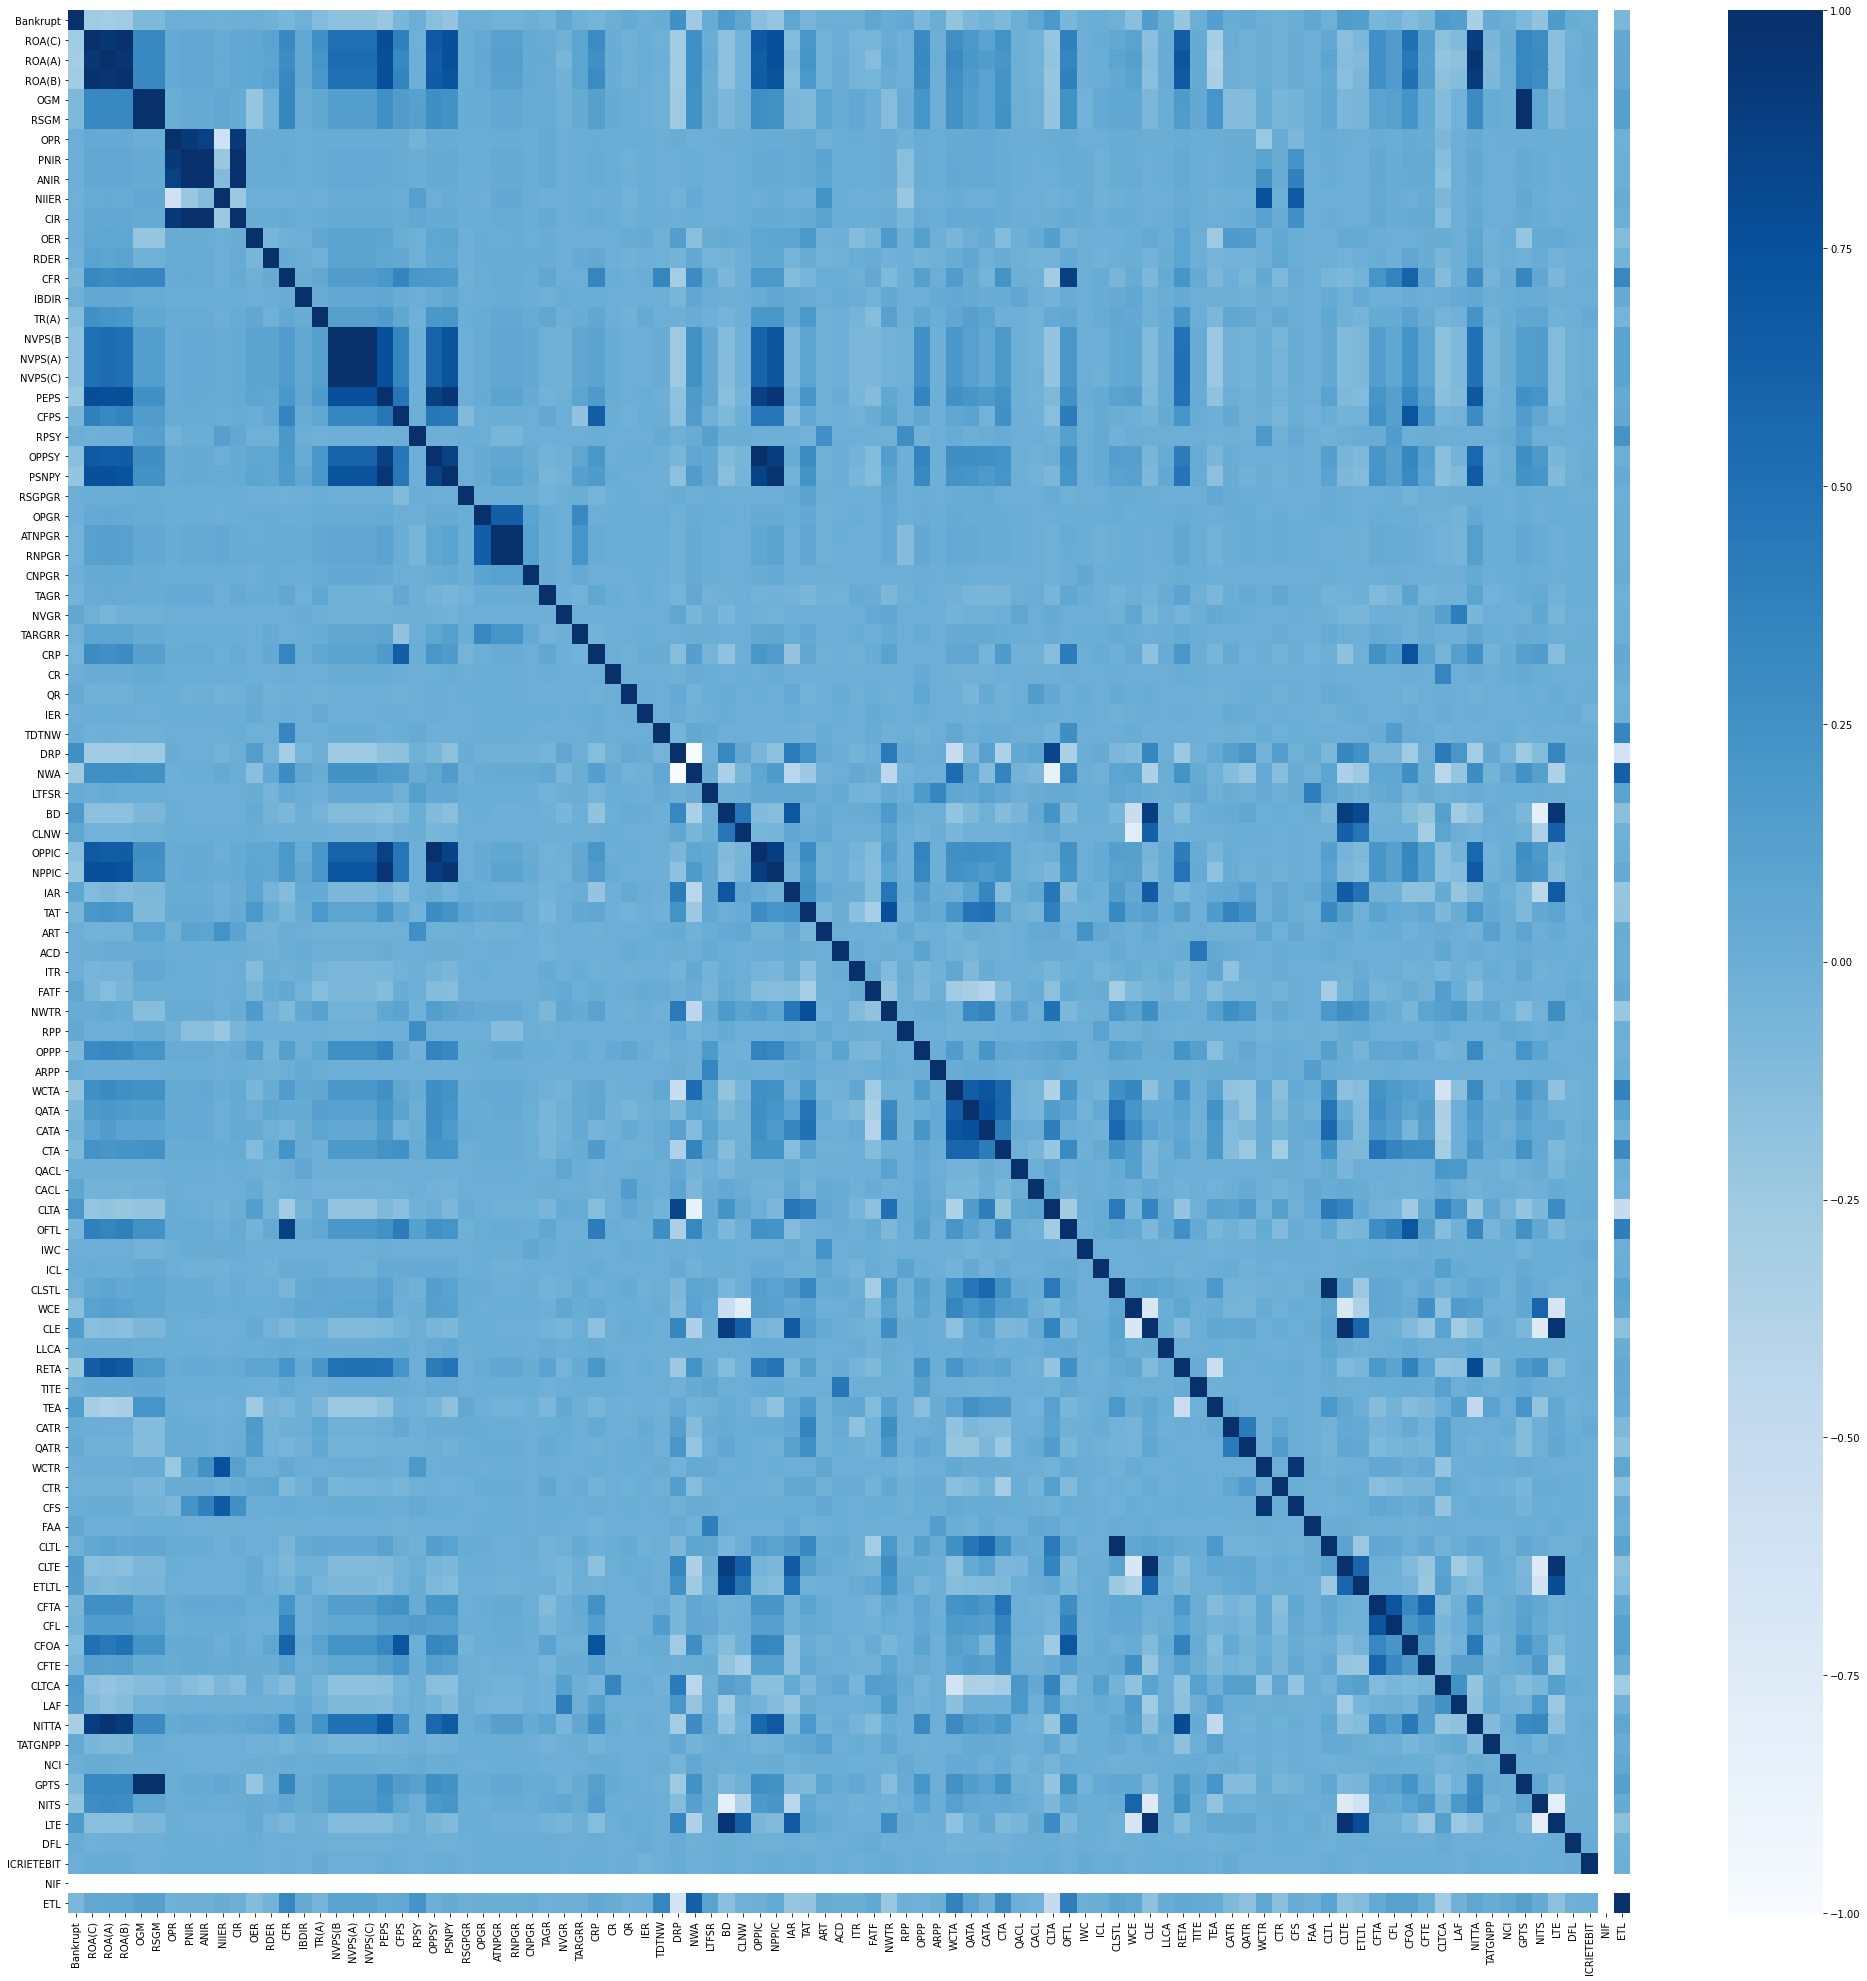

In [26]:
bankruptcy_corr = bankruptcy_pd.corr()
plt.figure(figsize=(35,35))
fig = sns.heatmap(bankruptcy_corr,cmap='Blues')
plt.show(fig)

In [29]:
print('max +ve correlation:',bankruptcy_corr.Bankrupt[1:].max())
print('max -ve correlation:',bankruptcy_corr.Bankrupt[1:].min())

max +ve correlation: 0.25016096206664595
max -ve correlation: -0.3154569716143331


<Figure size 3600x3600 with 0 Axes>

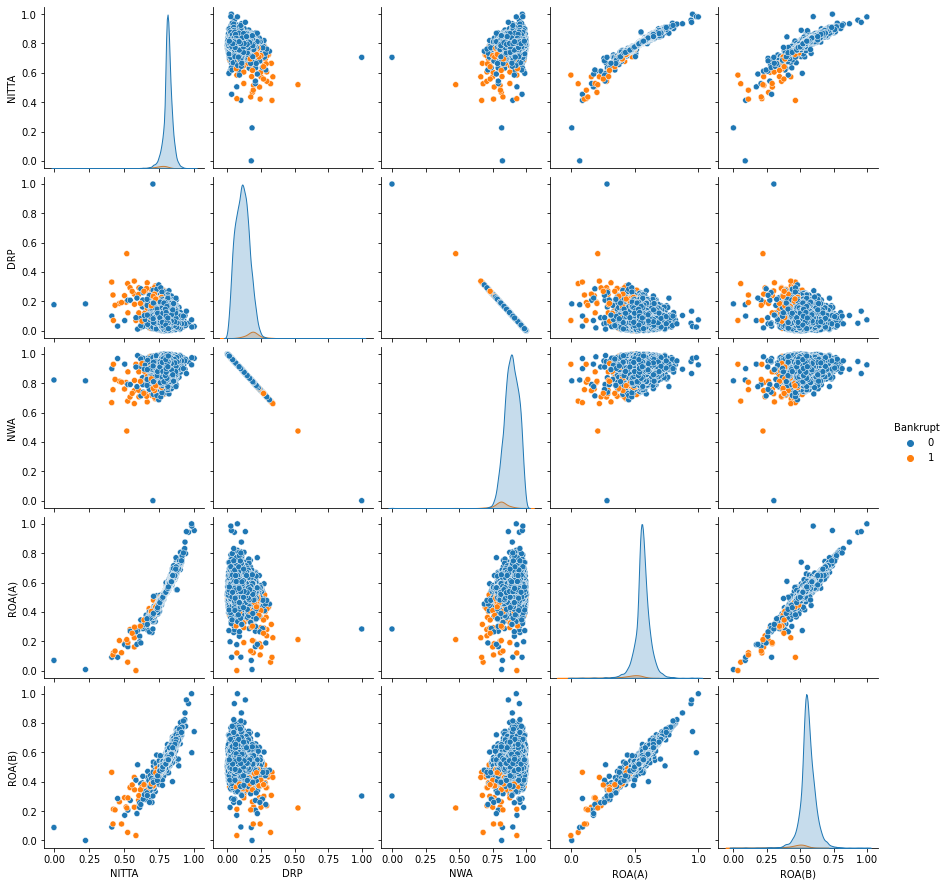

In [30]:
bankrupt_corr_col = ['NITTA','DRP','NWA','ROA(A)','ROA(B)','Bankrupt']
bank_pairplt = bankruptcy_pd[bankrupt_corr_col]
plt.figure(figsize=(50,50))
fig = sns.pairplot(bank_pairplt,hue='Bankrupt')
plt.show(fig)

<Figure size 7200x7200 with 0 Axes>

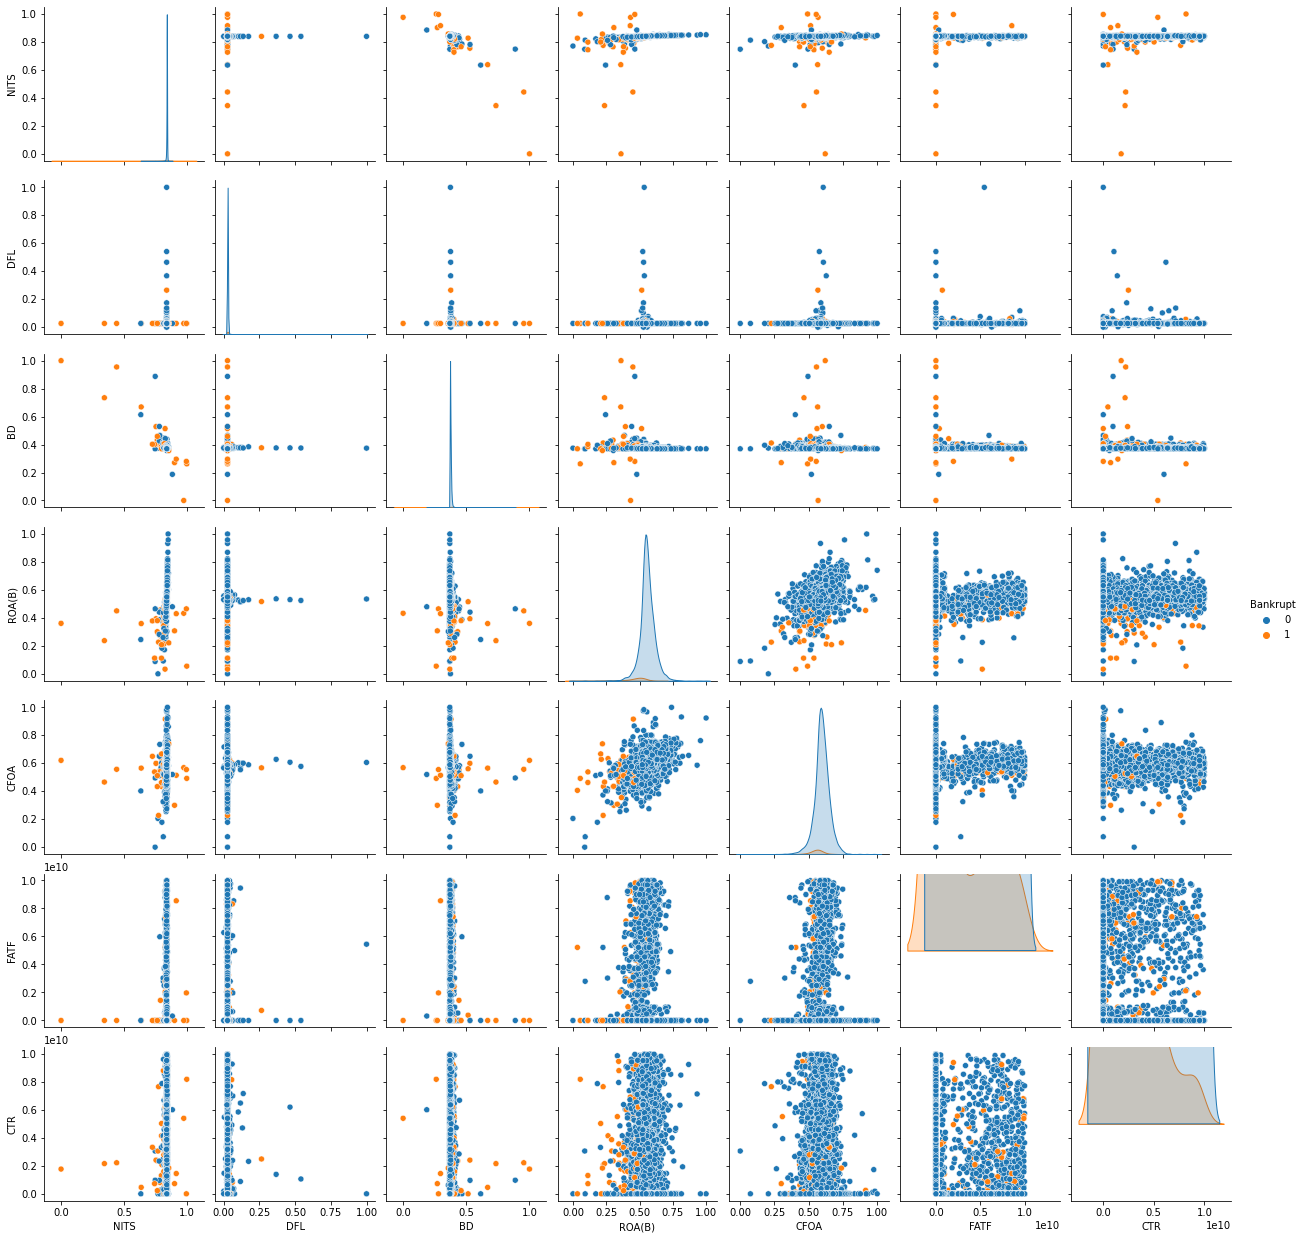

In [54]:
bankrupt_corr_col1 = ['NITS','DFL','BD','ROA(B)','CFOA', 'FATF', 'CTR','Bankrupt']
bankr_pairplt = bankruptcy_pd[bankrupt_corr_col1]
plt.figure(figsize=(100,100))
fig = sns.pairplot(bankr_pairplt,hue='Bankrupt')
plt.show(fig)

<a id='Dom_Feat'></a>
### 2.4 Dominant Features
<a id='PCA'></a>
### 2.4.1 PCA

* **check for the number of principal components that explains between 80% to 90% of the variance in the model** 

In [34]:
# drop the two categorical columns
dropcol = ['LAF','NIF','Bankrupt']
bankruptcy_pdd = bankruptcy_pd.drop(dropcol,axis='columns')

In [35]:
scaler = StandardScaler()
scaler.fit(bankruptcy_pdd)
df =scaler.transform(bankruptcy_pdd)

In [36]:
pca =PCA()
bankruptcy_pca = pca.fit_transform(df)
print("number of principal components:{}".format(pca.n_components_))
print("number of principal components:{}".format(pca.n_features_))
print(pca.explained_variance_ratio_)

number of principal components:93
number of principal components:93
[1.34817608e-01 7.25636290e-02 5.02941882e-02 4.76171995e-02
 4.28024713e-02 3.17030095e-02 3.08180387e-02 2.95237341e-02
 2.82638336e-02 2.15769144e-02 2.03827183e-02 2.00465423e-02
 1.80755995e-02 1.61627484e-02 1.59442277e-02 1.53969052e-02
 1.41231734e-02 1.38444731e-02 1.32738510e-02 1.27183065e-02
 1.23717140e-02 1.17799621e-02 1.15988792e-02 1.12286462e-02
 1.12057113e-02 1.09975472e-02 1.08668205e-02 1.08432819e-02
 1.08191667e-02 1.05934297e-02 1.04772314e-02 1.03764583e-02
 1.02984068e-02 1.02238421e-02 1.00848078e-02 9.87792772e-03
 9.77457583e-03 9.71297962e-03 9.46001445e-03 9.15091928e-03
 9.09481884e-03 8.92286737e-03 8.62108443e-03 8.54682964e-03
 8.13131801e-03 7.70713544e-03 7.26303819e-03 6.80390682e-03
 6.31922816e-03 5.84383903e-03 5.80419547e-03 5.41396667e-03
 5.22273150e-03 4.76476209e-03 4.51486889e-03 4.39300390e-03
 3.90527235e-03 3.50129365e-03 3.14549869e-03 2.69201997e-03
 2.32266553e-03 2

Text(0.5, 1.0, 'cummulative explained variance ratio')

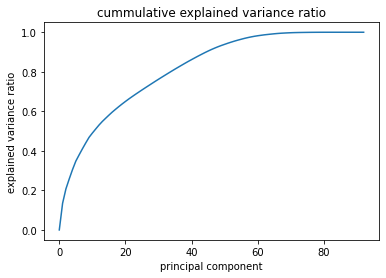

In [38]:
L = []
sum = 0.0
for i in range(pca.n_components_):
    L.append(sum)
    sum += pca.explained_variance_ratio_[i]
plt.plot(L)
plt.xlabel('principal component')
plt.ylabel('explained variance ratio')
plt.title('cummulative explained variance ratio')

In [39]:
print(pca.singular_values_)

[2.92398492e+02 2.14516803e+02 1.78591474e+02 1.73773578e+02
 1.64754104e+02 1.41792110e+02 1.39799081e+02 1.36831933e+02
 1.33880508e+02 1.16975925e+02 1.13692776e+02 1.12751300e+02
 1.07065161e+02 1.01241699e+02 1.00554975e+02 9.88140131e+01
 9.46385255e+01 9.37000959e+01 9.17487781e+01 8.98082974e+01
 8.85761411e+01 8.64318416e+01 8.57649488e+01 8.43850511e+01
 8.42988277e+01 8.35121639e+01 8.30143297e+01 8.29243726e+01
 8.28321104e+01 8.19634279e+01 8.15126641e+01 8.11197105e+01
 8.08140443e+01 8.05209493e+01 7.99715717e+01 7.91470517e+01
 7.87319086e+01 7.84834451e+01 7.74546899e+01 7.61788096e+01
 7.59449404e+01 7.52235870e+01 7.39405656e+01 7.36214460e+01
 7.18095645e+01 6.99114509e+01 6.78673643e+01 6.56872376e+01
 6.33043914e+01 6.08766775e+01 6.06698379e+01 5.85948718e+01
 5.75507078e+01 5.49695814e+01 5.35086989e+01 5.27816076e+01
 4.97653981e+01 4.71211724e+01 4.46628645e+01 4.13181586e+01
 3.83791327e+01 3.82573267e+01 3.40734053e+01 3.36724419e+01
 3.28613401e+01 3.103279

* **Number of dominant components 50**

<a id='Feature_Importance'></a>
### 2.4.2 Feature importance

* **The dataset has class imbalance**
* **It is therefore skewed towards the majority class**
* **Use SMOTE on the entire dataset and then extract the feature importances**

In [48]:
X_df = bankruptcy_pd.drop('Bankrupt', axis=1)
y = bankruptcy_pd['Bankrupt']

In [49]:
scaler = StandardScaler()
scaler.fit(X_df)
X =scaler.transform(X_df)

In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
# set the test train split to a low number to take entire set in the train set
X_train_w,X_test_w,y_train_w,y_test_w = train_test_split(X,y,test_size=0.001,random_state=42)
sm = SMOTE(random_state = 2)
X_train_res_w, y_train_res_w = sm.fit_sample(X_train_w,y_train_w.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [52]:
model_RF = RandomForestClassifier(n_estimators=100,max_depth=5)     # 2. instantiate model
model_RF.fit(X_train_res_w, y_train_res_w.ravel()) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

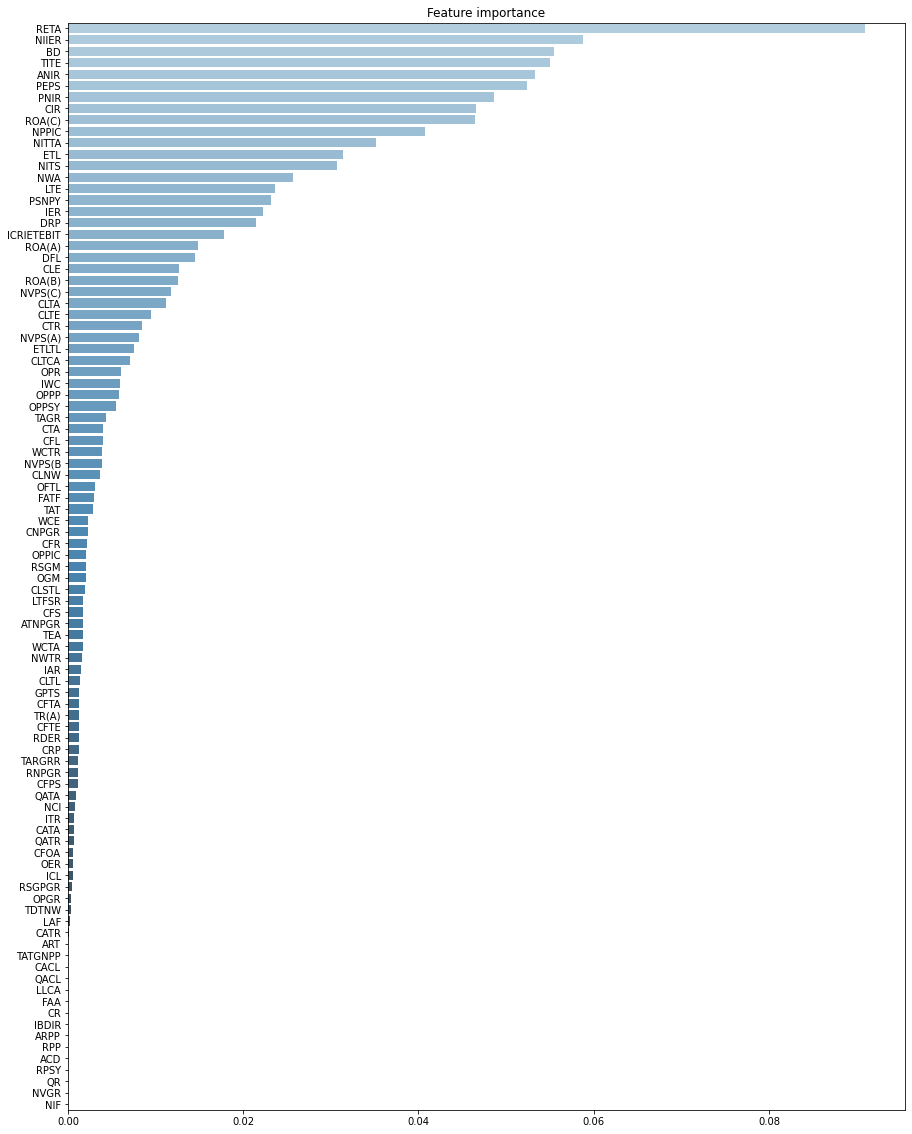

In [53]:
import pandas as pd
imp = pd.Series(data=model_RF.feature_importances_, index=X_df.columns).sort_values(ascending=False)
plt.figure(figsize=(15,20))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

<a id='Distributions'></a>
### 2.4.3 Distributions for some features

In [40]:
bankr_imp = bankruptcy.drop(*dropcol)
expr0 = col('Bankrupt') == 0
expr1 = col('Bankrupt') == 1
bankr_0 = bankr_imp.where(expr0).drop("Bankrupt")
bankr_1 = bankr_imp.where(expr1)
bankr_0_py = bankr_0.toPandas()
bankr_1_py = bankr_1.toPandas()

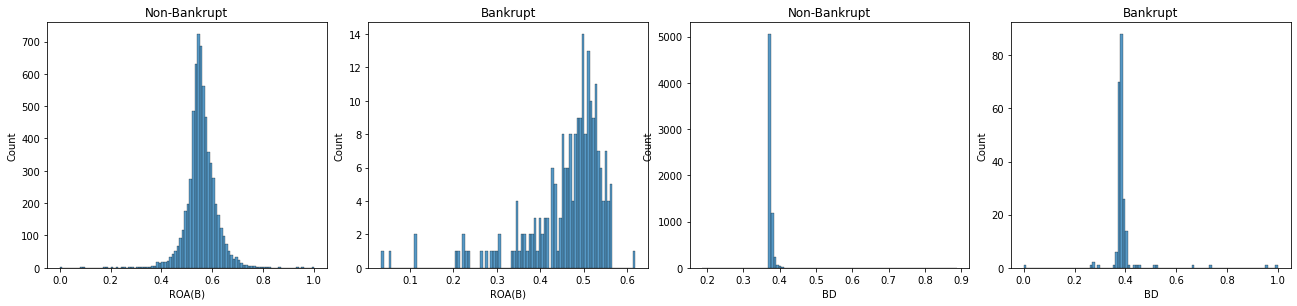

In [41]:
fig,ax=plt.subplots(1,4, figsize=(18,4))
fig.tight_layout()
sns.histplot(data=bankr_0_py,x='ROA(B)',bins=100,ax=ax[0])
sns.histplot(data=bankr_1_py,x='ROA(B)',bins=100,ax=ax[1])
sns.histplot(data=bankr_0_py,x='BD',bins=100,ax=ax[2])
sns.histplot(data=bankr_1_py,x='BD',bins=100,ax=ax[3])
ax[0].set_title('Non-Bankrupt')
ax[1].set_title('Bankrupt')
ax[2].set_title('Non-Bankrupt')
ax[3].set_title('Bankrupt')
fig.show()

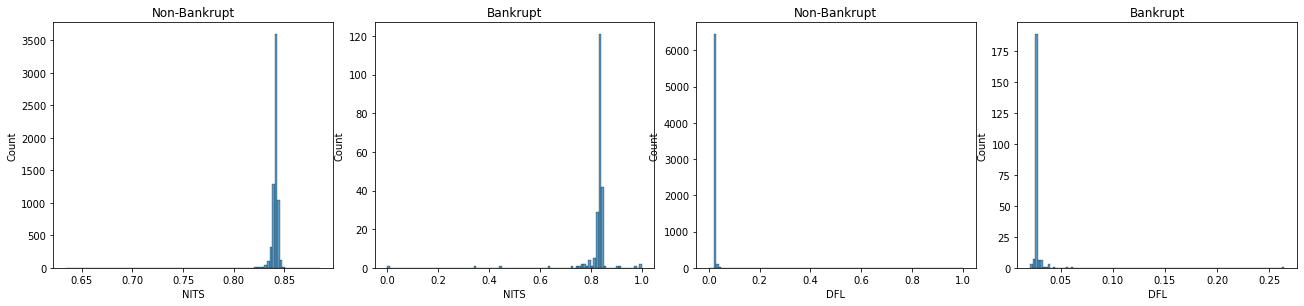

In [42]:
fig,ax=plt.subplots(1,4, figsize=(18,4))
fig.tight_layout()
sns.histplot(data=bankr_0_py,x='NITS',bins=100,ax=ax[0])
sns.histplot(data=bankr_1_py,x='NITS',bins=100,ax=ax[1])
sns.histplot(data=bankr_0_py,x='DFL',bins=100,ax=ax[2])
sns.histplot(data=bankr_1_py,x='DFL',bins=100,ax=ax[3])
ax[0].set_title('Non-Bankrupt')
ax[1].set_title('Bankrupt')
ax[2].set_title('Non-Bankrupt')
ax[3].set_title('Bankrupt')
fig.show()

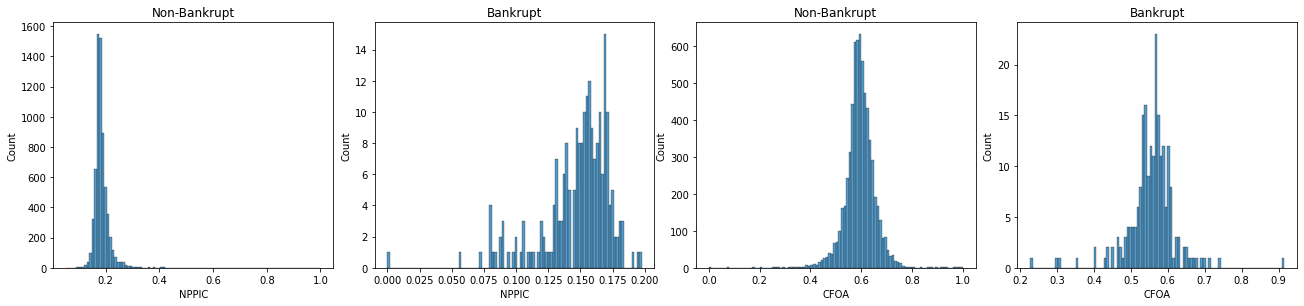

In [43]:
fig,ax=plt.subplots(1,4, figsize=(18,4))
fig.tight_layout()
sns.histplot(data=bankr_0_py,x='NPPIC',bins=100,ax=ax[0])
sns.histplot(data=bankr_1_py,x='NPPIC',bins=100,ax=ax[1])
sns.histplot(data=bankr_0_py,x='CFOA',bins=100,ax=ax[2])
sns.histplot(data=bankr_1_py,x='CFOA',bins=100,ax=ax[3])
ax[0].set_title('Non-Bankrupt')
ax[1].set_title('Bankrupt')
ax[2].set_title('Non-Bankrupt')
ax[3].set_title('Bankrupt')
fig.show()

In [44]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(bankruptcy_pd[bankruptcy_pd['Bankrupt'] == 0][feature].dropna(), color= 'navy')
    ax1 = sns.kdeplot(bankruptcy_pd[bankruptcy_pd['Bankrupt'] == 1][feature].dropna(), color= 'green')
    plt.legend(['Non Bankrupt','Bankrupt'], loc ='upper right')

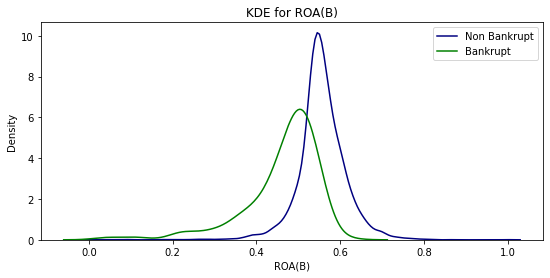

In [45]:
kdeplot('ROA(B)')

<a id='EDA_Summary'></a>
### 2.5 EDA Summary

* *There is significant class imbalance between bankrupt and non-bankrupt examples.*
* *The task is to predict of bankruptcy.*
* *But Only 3.23% of the data represent bankrupt cases*
* *Models trained with the dataset as is will learn about non-bankrupt cases but not about bankrupt cases as there are too few examples to learn from.* 

<a id='Data Preparation'></a>
## 3.0 Data preparation

<a id='LOF'></a>
### 3.1 Outlier Detection: Local outlier factor detection

In [55]:
rawData = bankruptcy.toPandas()
rawData.drop(["Bankrupt",'NIF','LAF'], axis=1, inplace=True)
LOFData = rawData.copy()
columns = rawData.columns
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto',algorithm='kd_tree',leaf_size=5)
df_pred = lof.fit_predict(LOFData)
lofs_index = where(df_pred==-1)

In [56]:
print("Number of rows with outlier datapoints:",len(lofs_index[0]))

Number of rows with outlier datapoints: 643


* **Drop rows that were found by outlier detection. 643 rows dropped.**
* **Compare summary statistics of the clean data set with the original dataset**

In [57]:
for row in range(len(df_pred)):
    if df_pred[row] == -1:
      LOFData.drop(labels=row,axis=0,inplace=True)
LOFData.shape

(6176, 93)

In [58]:
LOFData['Bankrupt'] = bankruptcy.toPandas()['Bankrupt']
LOFData['LAF'] = bankruptcy.toPandas()['LAF']
LOFData.describe()

,ROA(C),ROA(A),ROA(B),OGM,RSGM,OPR,PNIR,ANIR,NIIER,CIR,OER,RDER,CFR,IBDIR,TR(A),NVPS(B,NVPS(A),NVPS(C),PEPS,CFPS,RPSY,OPPSY,PSNPY,RSGPGR,OPGR,ATNPGR,RNPGR,CNPGR,TAGR,NVGR,TARGRR,CRP,CR,QR,IER,TDTNW,DRP,NWA,LTFSR,BD,...,CATA,CTA,QACL,CACL,CLTA,OFTL,IWC,ICL,CLSTL,WCE,CLE,LLCA,RETA,TITE,TEA,CATR,QATR,WCTR,CTR,CFS,FAA,CLTL,CLTE,ETLTL,CFTA,CFL,CFOA,CFTE,CLTCA,NITTA,TATGNPP,NCI,GPTS,NITS,LTE,DFL,ICRIETEBIT,ETL,Bankrupt,LAF
count,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6.176000e+03,6.176000e+03,6176.000000,6.176000e+03,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6.176000e+03,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6.176000e+03,6176.000000,6176.000000,6176.000000,6176.000000,...,6176.000000,6176.000000,6176.000000,6.176000e+03,6176.000000,6176.000000,6176.000000,6.176000e+03,6176.000000,6176.000000,6176.000000,6.176000e+03,6176.000000,6176.000000,6176.000000,6.176000e+03,6.176000e+03,6176.000000,6.176000e+03,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6.176000e+03,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000,6176.000000
mean,0.506586,0.560343,0.555080,0.607875,0.607856,0.998998,0.797430,0.809339,0.303534,0.781599,2.083387e+09,2.044561e+09,0.467385,1.407642e+07,0.116822,0.191266,0.191239,0.191275,0.229260,0.323612,0.039864,0.109419,0.184695,0.022420,0.848118,0.689266,0.689275,0.217690,5.596887e+09,0.000538,0.264290,0.379924,0.014689,0.010854,0.631014,7.674871e+04,0.112586,0.887414,0.008129,0.374612,...,0.523686,0.123326,0.011551,8.090026e+06,0.090039,0.353822,0.277332,2.306564e+07,0.760372,0.735829,0.331395,1.033378e+07,0.935645,0.002407,0.028688,1.258309e+09,2.282738e+09,0.593983,2.598181e+09,0.671572,0.246245,0.760372,0.331395,0.115624,0.649773,0.461574,0.594359,0.315599,0.030367,0.808954,1.032060e+06,0.623837,0.607873,0.840427,0.280352,0.027580,0.565399,0.046433,0.028012,0.000486
std,0.058706,0.062762,0.059314,0.015500,0.015481,0.000572,0.000915,0.000845,0.000714,0.000875,3.283550e+09,2.627771e+09,0.014563,1.010138e+08,0.138309,0.033309,0.033389,0.033398,0.032024,0.017351,0.045557,0.025763,0.031142,0.012664,0.002963,0.010985,0.011070,0.010150,2.837768e+09,0.001994,0.009529,0.020244,0.018472,0.017253,0.011707,6.031491e+06,0.051583,0.051583,0.021223,0.016562,...,0.214175,0.136324,0.017582,2.437698e+08,0.047904,0.031643,0.005415,3.940873e+08,0.204300,0.011717,0.013751,2.026203e+08,0.020964,0.000550,0.022544,2.890993e+09,3.438761e+09,0.000191,2.972588e+09,0.000194,0.193072,0.204300,0.013751,0.019692,0.044947,0.026415,0.056278,0.012971,0.021943,0.037085,5.426828e+07,0.011820,0.015500,0.014927,0.014828,0.016440,0.012772,0.041292,0.165019,0.022036
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.973424,0.752969,0.766198,0.279350,0.735093,1.000256e-04,0.000000e+00,0.000000,0.000000e+00,0.000000,0.102398,0.065063,0.065063,0.000000,0.000000,0.000151,0.000000,0.000000,0.000000,0.777860,0.180701,0.180701,0.095759,1.000017e-04,0.000122,0.251620,0.000000,0.000411,0.000100,0.000000,1.112540e-04,0.001512,0.673066,0.004129,0.000000,...,0.001407,0.000000,0.000135,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.523823,0.000000,0.000853,1.000008e-04,0.000000e+00,0.588417,0.000000e+00,0.661814,0.000000,0.000000,0.000000,0.025851,0.092089,0.000000,0.205248,0.000000,0.000000,0.224792,1.015558e-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008950,0.000000,0.000000
25%,0.477990,0.537056,0.528762,0.600513,0.600499,0.998972,0.797389,0.809314,0.303469,0.781570,1.565718e-04,1.369743e-04,0.461694,2.010201e-04,0.000000,0.174192,0.174192,0.174203,0.214995,0.317960,0.016425,0.096572,0.170746,0.022065,0.847986,0.689274,0.689274,0.217580,

In [62]:
rawData.describe()

,ROA(C),ROA(A),ROA(B),OGM,RSGM,OPR,PNIR,ANIR,NIIER,CIR,OER,RDER,CFR,IBDIR,TR(A),NVPS(B,NVPS(A),NVPS(C),PEPS,CFPS,RPSY,OPPSY,PSNPY,RSGPGR,OPGR,ATNPGR,RNPGR,CNPGR,TAGR,NVGR,TARGRR,CRP,CR,QR,IER,TDTNW,DRP,NWA,LTFSR,BD,...,WCTA,QATA,CATA,CTA,QACL,CACL,CLTA,OFTL,IWC,ICL,CLSTL,WCE,CLE,LLCA,RETA,TITE,TEA,CATR,QATR,WCTR,CTR,CFS,FAA,CLTL,CLTE,ETLTL,CFTA,CFL,CFOA,CFTE,CLTCA,NITTA,TATGNPP,NCI,GPTS,NITS,LTE,DFL,ICRIETEBIT,ETL
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6.819000e+03,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000
mean,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,0.781381,1.995347e+09,1.950427e+09,0.467431,1.644801e+07,0.115001,0.190661,0.190633,0.190672,0.228813,0.323482,1.328641e+06,0.109091,0.184361,0.022408,0.847980,0.689146,0.689150,0.217639,5.508097e+09,1.566212e+06,0.264248,0.379677,4.032850e+05,8.376595e+06,0.630991,4.416337e+06,0.113177,0.886823,0.008783,0.374654,...,0.814125,0.400132,0.522273,0.124095,3.592902e+06,3.715999e+07,0.090673,0.353828,0.277395,5.580680e+07,0.761599,0.735817,0.331410,5.416004e+07,0.934733,0.002549,0.029184,1.195856e+09,2.163735e+09,0.594006,2.471977e+09,0.671531,1.220121e+06,0.761599,0.331410,0.115645,0.649731,0.461849,0.593415,0.315582,0.031506,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,0.047578
std,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,0.012679,3.237684e+09,2.598292e+09,0.017036,1.082750e+08,0.138667,0.033390,0.033474,0.033480,0.033263,0.017611,5.170709e+07,0.027942,0.033180,0.012079,0.010752,0.013853,0.013910,0.010063,2.897718e+09,1.141594e+08,0.009634,0.020737,3.330216e+07,2.446847e+08,0.011238,1.684069e+08,0.053920,0.053920,0.028153,0.016286,...,0.059054,0.201998,0.218112,0.139251,1.716209e+08,5.103509e+08,0.050290,0.035147,0.010469,5.820516e+08,0.206677,0.011678,0.013488,5.702706e+08,0.025564,0.012093,0.027149,2.821161e+09,3.374944e+09,0.008959,2.938623e+09,0.009341,1.007542e+08,0.206677,0.013488,0.019529,0.047372,0.029943,0.058561,0.012961,0.030845,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,0.781567,1.566874e-04,1.281880e-04,0.461558,2.030203e-04,0.000000,0.173613,0.173613,0.173676,0.214711,0.3177

In [60]:
LOFData.groupby('Bankrupt').count()

,ROA(C),ROA(A),ROA(B),OGM,RSGM,OPR,PNIR,ANIR,NIIER,CIR,OER,RDER,CFR,IBDIR,TR(A),NVPS(B,NVPS(A),NVPS(C),PEPS,CFPS,RPSY,OPPSY,PSNPY,RSGPGR,OPGR,ATNPGR,RNPGR,CNPGR,TAGR,NVGR,TARGRR,CRP,CR,QR,IER,TDTNW,DRP,NWA,LTFSR,BD,...,QATA,CATA,CTA,QACL,CACL,CLTA,OFTL,IWC,ICL,CLSTL,WCE,CLE,LLCA,RETA,TITE,TEA,CATR,QATR,WCTR,CTR,CFS,FAA,CLTL,CLTE,ETLTL,CFTA,CFL,CFOA,CFTE,CLTCA,NITTA,TATGNPP,NCI,GPTS,NITS,LTE,DFL,ICRIETEBIT,ETL,LAF
Bankrupt,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,...,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003,6003
1,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,...,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173,173


* **Comparison shows improvement for RPSY,NVGR... etc. Some Bankrupt datapoints got eliminated**
* **Use LOF cleaned data for model training**

***One hot encode LAF categorical feature. NIF has already been dropped***

In [ ]:
bankruptcy_pd =pd.get_dummies(LOFData,columns=['LAF'],prefix='LAF')
bankruptcy_pd.head(2)

,ROA(C),ROA(A),ROA(B),OGM,RSGM,OPR,PNIR,ANIR,NIIER,CIR,OER,RDER,CFR,IBDIR,TR(A),NVPS(B,NVPS(A),NVPS(C),PEPS,CFPS,RPSY,OPPSY,PSNPY,RSGPGR,OPGR,ATNPGR,RNPGR,CNPGR,TAGR,NVGR,TARGRR,CRP,CR,QR,IER,TDTNW,DRP,NWA,LTFSR,BD,...,CTA,QACL,CACL,CLTA,OFTL,IWC,ICL,CLSTL,WCE,CLE,LLCA,RETA,TITE,TEA,CATR,QATR,WCTR,CTR,CFS,FAA,CLTL,CLTE,ETLTL,CFTA,CFL,CFOA,CFTE,CLTCA,NITTA,TATGNPP,NCI,GPTS,NITS,LTE,DFL,ICRIETEBIT,ETL,Bankrupt,LAF_0,LAF_1
0,0.370594,0.424389,0.40575,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,0.000126,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,0.390284,...,0.004094,0.001997,0.000147,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,0.016469,1,1,0
1,0.464291,0.538214,0.51673,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,0.000290,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,0.376760,...,0.014948,0.004136,0.001384,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,0.020794,1,1,0


In [ ]:
bankruptcy_pd.shape

(6176, 96)

<a id='Model_Training'></a>
## 4.0 Model Training

<a id='Model_TrainingBaseline'></a>
## 4.1.1. Baseline model without oversampling

* **Apply Standard scaling to LOF cleaned dataset and split into train and test sets**

In [63]:
X_df = bankruptcy_pd.drop('Bankrupt', axis=1)
y = bankruptcy_pd['Bankrupt']

In [64]:
scaler = StandardScaler()
scaler.fit(X_df)
X =scaler.transform(X_df)

In [65]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

* **Random Forest without oversampling**

In [66]:
model_RF_NOVS = RandomForestClassifier(n_estimators=100,max_depth=5)     # 2. instantiate model
model_RF_NOVS.fit(X_train, y_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [67]:
y_pred_novs = model_RF_NOVS.predict(X_test)
y_pred_novs_prob = model_RF_NOVS.predict_proba(X_test)[:,1]

In [68]:
print(classification_report(y_test,y_pred_novs, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_novs))
precision, recall,_ = precision_recall_curve(y_test,y_pred_novs_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_novs_prob))
print('PR_AUC: ',auc(recall,precision))

              precision    recall  f1-score   support

           0     0.9651    0.9985    0.9815      1968
           1     0.7000    0.0897    0.1591        78

    accuracy                         0.9638      2046
   macro avg     0.8326    0.5441    0.5703      2046
weighted avg     0.9550    0.9638    0.9502      2046

confusion matrix:
[[1965    3]
 [  71    7]]
AUC:  0.9375912028351053
PR_AUC:  0.45686099294007804


* **Very low recall score of less than 0.09 for bankruptcy class**

* **Check the number of bankrupt vs non-bankrupt before SMOTE**

In [69]:
ib = 0
inb = 0
for i in range(len(y_train)):
    #print(y_train.iloc[i])
    if y_train.iloc[i] == 1:
        ib += 1
    elif y_train.iloc[i] == 0:
        inb += 1
print('number of bankrupt:',ib)
print('number of non-bankrupt:',inb)
#y_train.head()

number of bankrupt: 142
number of non-bankrupt: 4631


<a id='Model_Training_SMOTE'></a>
## 4.1.2. Model training with oversampling: SMOTE

* **Setup Test-Train split with SMOTE**

In [70]:
sm = SMOTE(random_state = 2)
X_train_smt, y_train_smt = sm.fit_sample(X_train,y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


* **Check the number of bankrupt vs non-bankrupt after SMOTE**

In [71]:
ib = 0
inb = 0
for i in range(len(y_train_smt)):
    #print(y_train.iloc[i])
    if y_train_smt[i] == 1:
        ib += 1
    elif y_train_smt[i] == 0:
        inb += 1
print('number of bankrupt:',ib)
print('number of non-bankrupt:',inb)
#y_train.head()

number of bankrupt: 4631
number of non-bankrupt: 4631


* **Random Forest with SMOTE** 

In [72]:
model_RF_OVS = RandomForestClassifier(n_estimators=100,max_depth=5)     
model_RF_OVS.fit(X_train_smt, y_train_smt.ravel()) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [73]:
y_pred_ovs = model_RF_OVS.predict(X_test)
y_pred_ovs_prob = model_RF_OVS.predict_proba(X_test)[:,1]

In [74]:
print(classification_report(y_test,y_pred_ovs, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_ovs))
precision, recall,_ = precision_recall_curve(y_test,y_pred_ovs_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_ovs_prob))
print('PR_AUC: ',auc(recall,precision))

              precision    recall  f1-score   support

           0     0.9904    0.8918    0.9385      1968
           1     0.2226    0.7821    0.3466        78

    accuracy                         0.8876      2046
   macro avg     0.6065    0.8369    0.6425      2046
weighted avg     0.9611    0.8876    0.9159      2046

confusion matrix:
[[1755  213]
 [  17   61]]
AUC:  0.9334935897435899
PR_AUC:  0.3731382708151278


* **Comparison of ROC curves without (NOVS) and with (OVS) SMOTE**

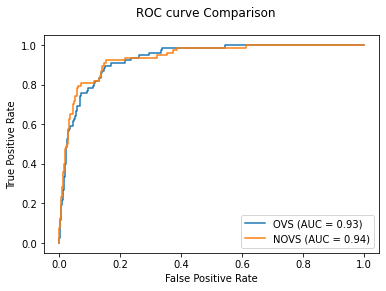

In [75]:
ovs = metrics.plot_roc_curve(model_RF_OVS, X_test, y_test,None,True,'auto','OVS')  

novs = metrics.plot_roc_curve(model_RF_NOVS, X_test, y_test,None,True,'auto','NOVS',ovs.ax_)  
novs.figure_.suptitle("ROC curve Comparison")
plt.show() 

* **With SMOTE Recall score for bankruptcy class has increased to 0.78**

* **clean data set: RECALL without SMOTE=0.09 and RECALL with SMOTE=0.78**

<a id='Model_Training_US'></a>
## 4.1.3. Model training with undersampling: Near Miss

* **Try Under-sampling majority class**
* **Setup Test-Train split with NearMiss Algorithm: under sample**

In [77]:
nr = NearMiss()
X_train_miss, y_train_miss = nr.fit_sample(X_train,y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


* **Random Forest with Near Miss algorithm**

In [78]:
model_RF = RandomForestClassifier(n_estimators=100,max_depth=5)     # 2. instantiate model
model_RF.fit(X_train_miss, y_train_miss.ravel()) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [79]:
y_pred = model_RF.predict(X_test)
y_pred_prob = model_RF.predict_proba(X_test)[:,1]

In [81]:
print(classification_report(y_test,y_pred, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred))
precision, recall,_ = precision_recall_curve(y_test,y_pred_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_prob))
print('PR_AUC: ',auc(recall,precision))

              precision    recall  f1-score   support

           0     0.9872    0.7820    0.8727      1968
           1     0.1191    0.7436    0.2053        78

    accuracy                         0.7805      2046
   macro avg     0.5531    0.7628    0.5390      2046
weighted avg     0.9541    0.7805    0.8473      2046

confusion matrix:
[[1539  429]
 [  20   58]]
AUC:  0.8429682614133834
PR_AUC:  0.34349244973728205


* **With under sampling Recall increased to 0.74 for bankruptcy class**
* **Because there are so few data points in out set we will go with SMOTE**

<a id='BM'></a>
## 4.1.3. Model Building: SMOTE

***Setup Test-Train wplit with SMOTE***

In [82]:
sm = SMOTE(random_state = 2)
X_train_smt, y_train_smt = sm.fit_sample(X_train,y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


***Decision Tree***

In [83]:
### Decision Tree Classifier model #####
model_DT = DecisionTreeClassifier(max_depth=5)     # 2. instantiate model
model_DT.fit(X_train_smt, y_train_smt)  

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [84]:
y_pred_DT = model_DT.predict(X_test)
y_pred_DT_prob = model_DT.predict_proba(X_test)[:,1]

In [85]:
print(classification_report(y_test,y_pred_DT, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_DT))
precision, recall,_ = precision_recall_curve(y_test,y_pred_DT_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_DT_prob))
print('PR_AUC: ',auc(recall,precision))

              precision    recall  f1-score   support

           0     0.9837    0.8918    0.9355      1968
           1     0.1870    0.6282    0.2882        78

    accuracy                         0.8817      2046
   macro avg     0.5854    0.7600    0.6119      2046
weighted avg     0.9534    0.8817    0.9108      2046

confusion matrix:
[[1755  213]
 [  29   49]]
AUC:  0.8359391286220554
PR_AUC:  0.19661780924129554


***Support Vector Machine***

In [90]:
model_linear_SVM = Pipeline([  ("linear_svc", LinearSVC(C=1, loss="hinge"))  ])
model_linear_SVM.fit(X_train_smt, y_train_smt)
y_pred_SVM = model_linear_SVM.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [91]:
print(classification_report(y_test,y_pred_SVM, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_SVM))

              precision    recall  f1-score   support

           0     0.9896    0.8745    0.9285      1968
           1     0.1954    0.7692    0.3117        78

    accuracy                         0.8705      2046
   macro avg     0.5925    0.8219    0.6201      2046
weighted avg     0.9594    0.8705    0.9050      2046

confusion matrix:
[[1721  247]
 [  18   60]]


***Naive Bayes***

In [92]:
model_GNB = GaussianNB()                       
model_GNB.fit(X_train_smt, y_train_smt)                  
y_pred_GNB = model_GNB.predict(X_test)
y_pred_GNB_prob = model_GNB.predict_proba(X_test)[:,1]

In [93]:
print(classification_report(y_test,y_pred_GNB, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_GNB))
precision, recall,_ = precision_recall_curve(y_test,y_pred_GNB_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_GNB_prob))
print('PR_AUC: ',auc(recall,precision))

              precision    recall  f1-score   support

           0     0.9847    0.2292    0.3718      1968
           1     0.0447    0.9103    0.0852        78

    accuracy                         0.2551      2046
   macro avg     0.5147    0.5697    0.2285      2046
weighted avg     0.9489    0.2551    0.3609      2046

confusion matrix:
[[ 451 1517]
 [   7   71]]
AUC:  0.6637644621638525
PR_AUC:  0.4746616506586935


***Logistic Regression***

In [94]:
model_LR = LogisticRegression(solver='liblinear')      
model_LR.fit(X_train_smt, y_train_smt)                           
y_pred_LR = model_LR.predict(X_test)
y_pred_LR_prob = model_LR.predict_proba(X_test)[:,1]

In [95]:
print(classification_report(y_test,y_pred_LR, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_LR))
precision, recall,_ = precision_recall_curve(y_test,y_pred_LR_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_LR_prob))
print('PR_AUC: ',auc(recall,precision))

              precision    recall  f1-score   support

           0     0.9897    0.8801    0.9317      1968
           1     0.2027    0.7692    0.3209        78

    accuracy                         0.8759      2046
   macro avg     0.5962    0.8247    0.6263      2046
weighted avg     0.9597    0.8759    0.9084      2046

confusion matrix:
[[1732  236]
 [  18   60]]
AUC:  0.9256566604127581
PR_AUC:  0.4657684251459685


***KNN***

In [98]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_smt, y_train_smt) 
y_pred_knn = knn.predict(X_test)
y_pred_knn_prob = knn.predict_proba(X_test)[:,1]

In [99]:
print(classification_report(y_test,y_pred_knn, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_knn))
precision, recall,_ = precision_recall_curve(y_test,y_pred_knn_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_knn_prob))
print('PR_AUC: ',auc(recall,precision))

              precision    recall  f1-score   support

           0     0.9859    0.8877    0.9342      1968
           1     0.1934    0.6795    0.3011        78

    accuracy                         0.8798      2046
   macro avg     0.5897    0.7836    0.6177      2046
weighted avg     0.9557    0.8798    0.9101      2046

confusion matrix:
[[1747  221]
 [  25   53]]
AUC:  0.82350622785074
PR_AUC:  0.3512135422866387


<a id='BM_ADASYN'></a>
## 4.1.4. Model Building: ADASYN

**Random Forest**

In [100]:
adasyn = ADASYN(sampling_strategy='not majority', random_state=8)
X_train_new, y_train_new = adasyn.fit_resample(X_train,y_train)

rfc = RandomForestClassifier(n_estimators=100,max_depth=5)
rfc.fit(X_train_new, y_train_new)
y_pred_rfc = rfc.predict(X_test)
y_pred_prob = rfc.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred_rfc, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_rfc))
precision, recall,_ = precision_recall_curve(y_test,y_pred_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_prob))
print('PR_AUC: ',auc(recall,precision))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0     0.9926    0.8841    0.9352      1968
           1     0.2218    0.8333    0.3504        78

    accuracy                         0.8822      2046
   macro avg     0.6072    0.8587    0.6428      2046
weighted avg     0.9632    0.8822    0.9129      2046

confusion matrix:
[[1740  228]
 [  13   65]]
AUC:  0.935428392745466
PR_AUC:  0.3658923834063657


**Logistic Regression**

In [102]:
adasyn = ADASYN()
X_train_new, y_train_new = adasyn.fit_resample(X_train,y_train)

lr = LogisticRegression()
lr.fit(X_train_new, y_train_new)
y_pred_lr = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)[:,1]

print(classification_report(y_test,y_pred_lr, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_lr))
precision, recall,_ = precision_recall_curve(y_test,y_pred_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_prob))
print('PR_AUC: ',auc(recall,precision))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


              precision    recall  f1-score   support

           0     0.9890    0.8709    0.9262      1968
           1     0.1885    0.7564    0.3018        78

    accuracy                         0.8666      2046
   macro avg     0.5888    0.8137    0.6140      2046
weighted avg     0.9585    0.8666    0.9024      2046

confusion matrix:
[[1714  254]
 [  19   59]]
AUC:  0.9212007504690432
PR_AUC:  0.4424392034821888


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


***Grid Search Random Forest with ADASYN***

In [103]:
adasyn = ADASYN(sampling_strategy='not majority', random_state=8, n_neighbors=10)
X_train_new, y_train_new = adasyn.fit_resample(X_train,y_train)
param_grid = [
              {'n_estimators':[100,150],
               'max_depth':[5,7],
               'random_state':[841]}
]
rf = RandomForestClassifier()
grid_search = GridSearchCV(rf,param_grid,cv=5,scoring='recall',return_train_score=True)
grid_search.fit(X_train_new,y_train_new)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [104]:
final_model = grid_search.best_estimator_
y_pred_gs = final_model.predict(X_test)
y_pred_prob = final_model.predict_proba(X_test)[:,1]


In [106]:
print(classification_report(y_test,y_pred_gs, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_gs))
precision, recall,_ = precision_recall_curve(y_test,y_pred_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_prob))
print('PR_AUC: ',auc(recall,precision))

              precision    recall  f1-score   support

           0     0.9890    0.9131    0.9495      1968
           1     0.2533    0.7436    0.3779        78

    accuracy                         0.9066      2046
   macro avg     0.6211    0.8283    0.6637      2046
weighted avg     0.9609    0.9066    0.9277      2046

confusion matrix:
[[1797  171]
 [  20   58]]
AUC:  0.9357410881801126
PR_AUC:  0.3485638248168079


<a id='PAC_SMOTE'></a>
## 4.1.5 Model Building: PCA and SMOTE

* **Use SMOTE for over sampling**
* **PCA to pick dominant components**
* **Train model in the principal space***

In [107]:
X_df = bankruptcy_pd.drop('Bankrupt', axis=1)
y = bankruptcy_pd['Bankrupt']

In [108]:
scaler = StandardScaler()
scaler.fit(X_df)
X =scaler.transform(X_df)

In [109]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [110]:
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_sample(X_train,y_train.ravel())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [111]:
pca =PCA()
bankruptcy_pca = pca.fit_transform(X_train_res)
#print("number of principal components:{}".format(pca.n_components_))
#print("number of principal components:{}".format(pca.n_features_))
#print(pca.explained_variance_ratio_)

Text(0.5, 1.0, 'cummulative explained variance ratio')

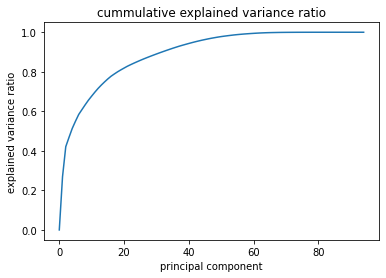

In [113]:
L = []
sum = 0.0
for i in range(pca.n_components_):
    L.append(sum)
    sum += pca.explained_variance_ratio_[i]
plt.plot(L)
plt.xlabel('principal component')
plt.ylabel('explained variance ratio')
plt.title('cummulative explained variance ratio')

***Plot Above shows that 40 components explains 90% variance***

In [114]:
pca =PCA(n_components=40)
pca.fit(X_train_res)
X_train_40 = pca.transform(X_train_res)
X_test_40 = pca.transform(X_test)
print("number of principal components:{}".format(pca.n_components_))
print("number of principal components:{}".format(pca.n_features_))
print(pca.explained_variance_ratio_)

number of principal components:40
number of principal components:95
[0.26950549 0.15161541 0.04698198 0.04531238 0.03645786 0.03426387
 0.0246039  0.02434931 0.02321561 0.02067101 0.02018289 0.01892132
 0.01707469 0.01581163 0.01500862 0.01364056 0.01132176 0.01079898
 0.00977655 0.00919376 0.00907769 0.00790931 0.00757695 0.0073192
 0.00712117 0.0068836  0.00658444 0.00640649 0.00625956 0.00613278
 0.00599956 0.00583702 0.00577727 0.00559913 0.00555684 0.00529424
 0.00519432 0.00478445 0.00462631 0.0045092 ]


In [115]:
rfc = RandomForestClassifier(n_estimators=100,max_depth=5)
rfc.fit(X_train_40, y_train_res)
y_pred_rfc = rfc.predict(X_test_40)
y_pred_prob = rfc.predict_proba(X_test_40)[:,1]

print(classification_report(y_test,y_pred_rfc, digits=4))
print('confusion matrix:')
print(confusion_matrix(y_test,y_pred_rfc))
precision, recall,_ = precision_recall_curve(y_test,y_pred_prob)
print('AUC: ',roc_auc_score(y_test,y_pred_prob))
print('PR_AUC: ',auc(recall,precision))

              precision    recall  f1-score   support

           0     0.9925    0.8740    0.9295      1968
           1     0.2077    0.8333    0.3325        78

    accuracy                         0.8724      2046
   macro avg     0.6001    0.8537    0.6310      2046
weighted avg     0.9626    0.8724    0.9067      2046

confusion matrix:
[[1720  248]
 [  13   65]]
AUC:  0.9256827183656452
PR_AUC:  0.31769691119375526


<a id='Conclusion'></a>
## 5.0 Conclusion

* *The task is to predict bankruptcy i.e. label =1. Therefore the recall score for label 1 is the critical metric for evaluating the performance of the model.*
* *The baseline case shows that the recall score for class label 1 is only 0.09.*
* *Using SMOTE and ADASYN to synthetically add minority class data, i.e. class label 1 considerably improve model's bankruptcy prediction capability.*
* *Models trained with SMOTE treated data show  a reacll of 0.7 or higher for class label 1.*
* *Models trained with ADASYN also show an improvement in the recall for class label 1.*
* *Using PCA on SMOTE treated data doesn't show any degradation in the recall performanace of the model. This can be an approach to speed up traning when we are dealing with a large feature space.*
* *The recall for the majority class, i.e. non-bankrupt (class label 0) drops from 0.99 to 0.9 when SMOTE or ADASYN is used.*
* *This compromise in the recall of the majority class is well worth the gains we make in the recall of the minority class*